# Pratical excersice 1: Chest and breast classification

Before you start to solve the exercise, please write your TUM-IDs alongside the names of all group members. This will enable us to assign grades accurately. Thank you.

Member 1: Sama Mohamed Mahmoud ElBaroudy

Member 2: Carlotta Sophia Hölzle

Member 3: Tuğcan Hoşer

Member 4: Valentin Biller

In [2]:
!pip install medmnist

In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from matplotlib import pyplot as plt

import medmnist
from medmnist import INFO

## Task 1: 2D breast ultrasound classification.

## Dataloading
We first load a 2D dataset breast ultrasound dataset-BreastMNIST, preprocess it and encapsulate it into dataloader form. Please fill the empty blanks in the following bloacks. You are expected to show the details of training, validation, and test dataset.

In [4]:
data_flag_2d = 'breastmnist' # here the name of dataset should be passed.
download = True

info = INFO[data_flag_2d] # INFO is embedded in the medmnist containing basic information of datasets
print(info)
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

{'python_class': 'BreastMNIST', 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.', 'url': 'https://zenodo.org/record/6496656/files/breastmnist.npz?download=1', 'MD5': '750601b1f35ba3300ea97c75c52ff8f6', 'task': 'binary-class', 'label': {'0': 'malignant', '1': 'normal, benign'}, 'n_channels': 1, 'n_samples': {'train': 546, 'val': 78, 'test': 156}, 'license': 'CC BY 4.0'}


In [5]:
"""
Here goes with the hyperparameters for your model.
"""
# hyparameters
BATCH_SIZE = 64
EPOCH_NUM = 10
lr = 0.001

In [6]:
"""
Please generate datasets and dataloaders for training, validation, and test dataset.
Datasets should be an object of DataClass and dataloaders should be an object of torch.utils.data.DataLoader.
"""

from medmnist import BreastMNIST

# preprocessing such as conversion to tensor and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# get the data class
train_dataset = BreastMNIST(split="train", transform=transform, download=True)
val_dataset = BreastMNIST(split="val", transform=transform, download=True)
test_dataset = BreastMNIST(split="test", transform=transform, download=True)

# encapsulate datasets into Dataloader form
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /Users/valentinbiller/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/valentinbiller/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/valentinbiller/.medmnist/breastmnist.npz


Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /Users/valentinbiller/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 78
    Root location: /Users/valentinbiller/.medmnist
    Split: val
    Task: binary-class
    Number of channels: 1
    Meaning of 

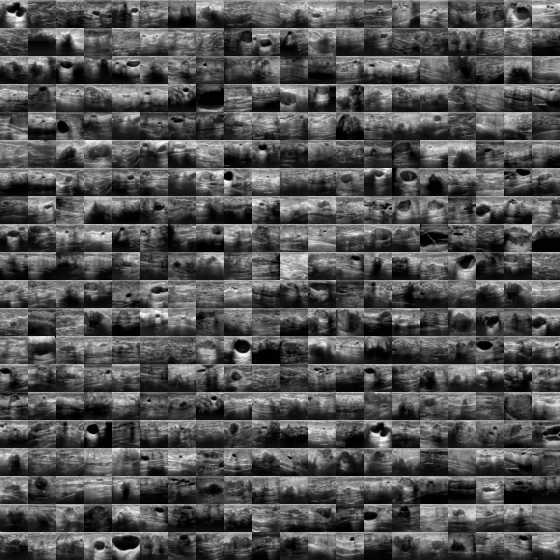

In [7]:
"""
This block shows the details of the datasets you generated above.
"""
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)
train_dataset.montage(length=20)

Please fill the blanks in the following block to show the image and its corresponding class label of 2 subjects:
1. the 50th subject in training dataset
2. the 20th subject in test dataset



<Figure size 640x480 with 0 Axes>

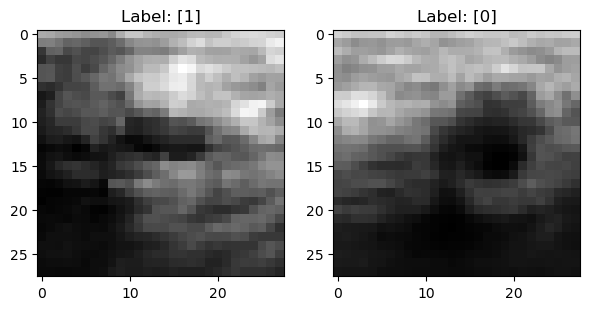

The size of images: torch.Size([1, 28, 28]).


In [12]:
"""
Please query images and labels and visualize both images with labels as title.
"""
# query images and corresponding labels
im_1, label_1 = train_dataset[50]
im_2, label_2 = test_dataset[20]

# visualization
plt.figure()
f, axarr = plt.subplots(1, 2, figsize=(7, 7))
axarr[0].imshow(im_1[0], cmap='gray')
axarr[0].set_title(f'Label: {label_1}')
axarr[1].imshow(im_2[0], cmap='gray')
axarr[1].set_title(f'Label: {label_2}')
plt.show()

print(f'The size of images: {im_1.shape}.')

## Upsampling and downsampling
Upsample the aforementioned subjects with bilinear algorithm from 28$\times$28 to 56$\times$56 and apply a 2D max pooling over the same subjects with kernel size equals 2 and stride equals 2.

**You are expected to use classes implememted in torch.nn.**
*Hit: Pay attention to the dimension of inputs.*


<Figure size 640x480 with 0 Axes>

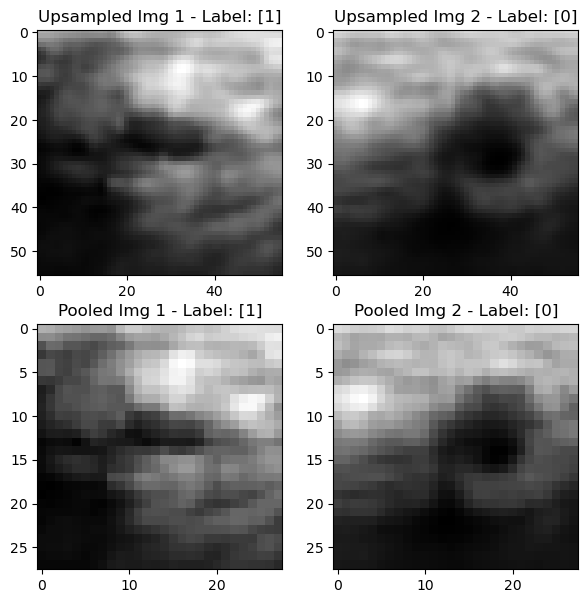

The size of resulted images (upsampled): torch.Size([1, 1, 56, 56]).
The size of resulted images (pooled): torch.Size([1, 1, 28, 28]).


In [14]:
"""
Please realize upsampling and pooling of target images.
Visualize them with 2*2 subplots and print the size of images.

"""

upsample = torch.nn.Upsample(size=(56, 56), mode='bilinear', align_corners=False)
pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

# upsampling
upsampled_im_1 = upsample(im_1.unsqueeze(0))
upsampled_im_2 = upsample(im_2.unsqueeze(0))

# downsampling
pooled_im_1 = pool(upsampled_im_1)
pooled_im_2 = pool(upsampled_im_2)

# visualization
plt.figure()
f, axarr = plt.subplots(2, 2, figsize=(7, 7))
axarr[0, 0].imshow(upsampled_im_1[0][0], cmap='gray')
axarr[0, 0].set_title(f'Upsampled Img 1 - Label: {label_1}')
axarr[0, 1].imshow(upsampled_im_2[0][0], cmap='gray')
axarr[0, 1].set_title(f'Upsampled Img 2 - Label: {label_2}')
axarr[1, 0].imshow(pooled_im_1[0][0], cmap='gray')
axarr[1, 0].set_title(f'Pooled Img 1 - Label: {label_1}')
axarr[1, 1].imshow(pooled_im_2[0][0], cmap='gray')
axarr[1, 1].set_title(f'Pooled Img 2 - Label: {label_2}')
plt.show()

print(f'The size of resulted images (upsampled): {upsampled_im_1.shape}.')
print(f'The size of resulted images (pooled): {pooled_im_1.shape}.')

## Model implementation

Here you should implement a basic CNN model with 5 convolutional layers. The output layer should be two linear layers. The output activation is sigmoid function.

Define a loss criterion that measures the Binary Cross Entropy between the target and the input probabilities with mean reduction.

In [ ]:
"""
Please design a CNN model. You are execpted to invole batch normalization and pooling.
"""

# define the architecture of the model
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()


    def forward(self, x):

        return x

# initialize your model
cnn_model =

# define the BCE loss function and an optimizer you prefer


Here shows the summary of designed CNN architecture.

In [ ]:
"""
Here shows the summary of the model you designed with input size of your data and batch size you chose.
Please pass the size of data size to SAMPLE_DATASIZE.
"""
from torchsummary import summary
SAMPLE_DATASIZE =
summary(cnn_model, SAMPLE_DATASIZE, BATCH_SIZE)

## Training and evaluation

Please fill the blanks in train and test functions.

In [ ]:
"""
Please define functions for training and testing.
- train:
    input: dataloader, model
    output: loss_values for training and validation which is a list containing losses for all epochs.
            trained_model
- test:
    input: dataloader, model
    output: auc, acc
    Please also plot the test ROC curve for each class.
"""
# train and validation
def train(train_loader, model):
    loss_values = []
    val_loss_values = []

    return loss_values, val_loss_values, model

# test
def test(test_loader, model):
    test_loss_values = []

    return auc, acc

In [ ]:
"""
Here shows the training and validation curves. AUC and ACC of test will also be printed.
"""
# train


# show training and validation curves


# test


print(f'auc: {}, acc: {}') # round both to the first 3 digits

# 3D dataset NoduleMNIST3D

Please fill the blanks in the following block to create dataloaders for training, validation, and test on 3D dataset. The visualization of each dataset is expected.

In [ ]:
# hyparameters
BATCH_SIZE =
EPOCH_NUM =
lr =

# dataset
data_flag_3d = 'nodulemnist3d' # here the name of dataset should be passed.
download = True

info =  # INFO is embedded in the medmnist containing basic information of datasets
print(info)
task =

n_channels =
n_classes =

# get the data class without transform

# encapsulate datasets into Dataloader form

# show the details
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)
train_dataset.montage(length=20)[10]

## 3D CNN implementation

Similar to what you have completed, please fill the blanks in following methods.

You expected to design a 3D CNN with 5 layers along with batch normalization and pooling.

In [ ]:
class CNN_3D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_3D, self).__init__()

    def forward(self, x):

        return x

# initialize the 3D model
cnn3d_model =

# define the BCE loss function and an optimizer you prefer
criterion =
optimizer =

# show the details
from torchsummary import summary
SAMPLE_DATASIZE =  # please pass the size of data size to SAMPLE_DATASIZE
summary(cnn3d_model, SAMPLE_DATASIZE, BATCH_SIZE)

## Training and evaluation

Please fill empty blanks in the following block and modify the train and test functions if it is necessary. Note that train and test functions should work for both 2D CNN and 3D CNN.

In [ ]:
"""
Here shows the training and validation curves. AUC and ACC of test will also be printed.
"""
# train


# show training and validation curves


# test


print(f'auc: {}, acc: {}') # round both to the first 3 digits

# What are the strengths and weaknesses of classification models?
### In the previous tasks, you worked on CNN and 3D CNN. What are other networks that can realize image classification? (Please make at least 3 examples.) Could you discuss the pros and cons of CNNs and the networks you listed in medical image classification?

### 1. Residual Neural Networks (ResNet):
      
#### Pros:
* ResNets introduced the concept of residual connections, which help mitigate the vanishing gradient problem. This enables the training of very deep networks, which can capture intricate features in medical images.
* ResNets have been highly successful in image classification tasks, achieving state-of-the-art results.
* Effective at feature extraction and classification.
       
#### Cons:
* Deeper networks can be computationally expensive and require substantial amounts of data for training.
* In medical image analysis, it may not always be necessary to use such deep networks, and simpler           architectures might suffice.
* Increased complexity may lead to overfitting, which can be a concern when data is limited.

### 2. Inception Networks (GoogLeNet):
 
#### Pros:
* Inception networks use a combination of multiple filter sizes within a single layer, allowing them to capture features at different scales (effective at handling multi-scale features).
* They are computationally efficient, making them a good choice for medical image classification where computational resources might be limited.

#### Cons:
* The architecture can be complex, making it harder to understand and fine-tune for specific medical image analysis tasks.
* The complex architecture may require careful tuning and a larger dataset to work optimally.

### 3. DenseNet (Densely Connected Convolutional Networks):
       
#### Pros:
* DenseNet introduces a unique architecture where each layer is connected to all subsequent layers. This promotes feature reuse and helps in the efficient propagation of gradients.
* Dense connections can lead to better/more effective feature extraction with fewer parameters.
* Faster convergence and improved accuracy compared to traditional CNNs.
       
#### Cons:
* DenseNet can be memory-intensive due to its dense connectivity, which might be a concern when dealing with large medical image datasets (may limit its use in some hardware environments).
* As with ResNets, very deep DenseNet models may require extensive computational resources.

### CNNs (Convolutional Neural Networks):

#### Pros:
* Well-established and widely used in various medical image analysis tasks.
* Can be adapted to different data modalities, such as X-rays, MRIs, and CT scans.
        
#### Cons:
* Might struggle with very deep architectures due to vanishing gradients.
* Performance heavily depends on the choice of architecture and hyperparameters.